In [6]:
import wradlib as wrl
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

from osgeo import osr

import pickle

import pyart
import datetime as dt
import numpy as np
import pandas as pd
import os

In [7]:
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
import matplotlib.patches as patches

In [8]:
# import os

# os.environ['LC_NUMERIC']='C'

Read the radar grid coordinates. These coordinates are in WGS84 CRS.

In [42]:
# Getting back the objects:
with open('radar_grid_600x600.pkl','rb') as f:  # Python 3: open(..., 'rb')
    x_rad, y_rad = pickle.load(f)

In [43]:
x_rad.shape

(600, 600)

Read the watershed shapefile.

In [44]:
# this file is in UTM
fname_shp = r'C:/Users/iac6311/Documents/Work/Data/GIS/USA/SAVEUR/city_detailed_utm.shp'

In [45]:
dataset, inLayer = wrl.io.open_vector(fname_shp)
borders, keys = wrl.georef.get_vector_coordinates(inLayer, key='node_id')

Define different projections that will be used in the processing.

In [46]:
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(4326)

proj_aeqd = osr.SpatialReference()
proj_aeqd.ImportFromEPSG(54032)

proj_IL = osr.SpatialReference()
proj_IL.ImportFromEPSG(26771)

proj_IL_UTM = osr.SpatialReference()
proj_IL_UTM.ImportFromEPSG(26916)

0

Put the two coordinate grids in one array.

In [47]:
grid_xy = np.zeros((600,600,2))

grid_xy[:,:,0] = x_rad
grid_xy[:,:,1] = y_rad

Reproject the radar grid to UTM, to match the shapefile.

In [48]:
grid_xy_utm = wrl.georef.reproject(grid_xy,
                                projection_source=proj_wgs,
                                projection_target=proj_IL_UTM)

# grid_xy_utm = wrl.georef.reproject(grid_xy,
#                                 projection_source=proj_aeqd,
#                                 projection_target=proj_IL_UTM)

In [49]:
x_rad_utm = grid_xy_utm[:,:,0]
y_rad_utm = grid_xy_utm[:,:,1]

Create a mask to reduce size.

In [50]:
# Reduce grid size using a bounding box (to enhancing performance)
bbox = inLayer.GetExtent()

In [51]:
print(bbox) # in UTM

(429833.0111856869, 454775.7552739343, 4619778.345386352, 4657770.209322866)


In [52]:
buffer = 5000.
bbox = dict(left=bbox[0] - buffer, right=bbox[1] + buffer,
            bottom=bbox[2] - buffer, top=bbox[3] + buffer)
mask = (((grid_xy_utm[..., 1] > bbox['bottom']) & (grid_xy_utm[..., 1] < bbox['top'])) &
        ((grid_xy_utm[..., 0] > bbox['left']) & (grid_xy_utm[..., 0] < bbox['right'])))

In [53]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Have a look at the mask.

(600, 600)


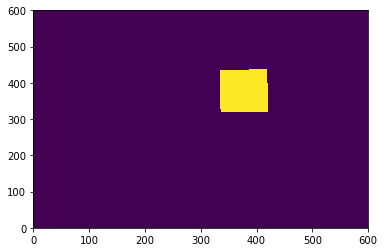

In [54]:
print(mask.shape)
plt.pcolormesh(mask)

In [55]:
# Create vertices for each grid cell
# (MUST BE DONE IN NATIVE COORDINATES)

grdverts = wrl.zonalstats.grid_centers_to_vertices(x_rad_utm[mask],
                                                   y_rad_utm[mask], 824,
                                                   824)

In [56]:
# # And reproject to Cartesian reference system (here: UTM)
# grdverts = wrl.georef.reproject(grdverts,
#                                 projection_source=proj_wgs,
#                                 projection_target=proj_IL_UTM)

In [57]:
grdverts.shape

(9930, 5, 2)

In [58]:
x_rad

array([[-89.53860964, -89.5337543 , -89.52889895, ..., -86.63943601,
        -86.63458066, -86.62972532],
       [-89.5386903 , -89.53383469, -89.52897907, ..., -86.63935589,
        -86.63450027, -86.62964467],
       [-89.53877096, -89.53391509, -89.5290592 , ..., -86.63927576,
        -86.63441988, -86.629564  ],
       ...,
       [-89.58916019, -89.58413621, -89.57911222, ..., -86.58922274,
        -86.58419875, -86.57917477],
       [-89.58924908, -89.58422481, -89.57920052, ..., -86.58913444,
        -86.58411016, -86.57908588],
       [-89.58933799, -89.58431341, -89.57928883, ..., -86.58904613,
        -86.58402155, -86.57899697]])

In [59]:
y_rad

array([[40.48902186, 40.48908355, 40.48914503, ..., 40.48914503,
        40.48908355, 40.48902186],
       [40.49271449, 40.49277619, 40.49283768, ..., 40.49283768,
        40.49277619, 40.49271449],
       [40.49640713, 40.49646883, 40.49653033, ..., 40.49653033,
        40.49646883, 40.49640713],
       ...,
       [42.69350627, 42.69357104, 42.69363558, ..., 42.69363558,
        42.69357104, 42.69350627],
       [42.69719884, 42.69726361, 42.69732816, ..., 42.69732816,
        42.69726361, 42.69719884],
       [42.70089141, 42.70095618, 42.70102074, ..., 42.70102074,
        42.70095618, 42.70089141]])

In [60]:
grdverts[0]

array([[ 424790.82739973, 4614637.03707477],
       [ 425614.82739973, 4614637.03707477],
       [ 425614.82739973, 4615461.03707477],
       [ 424790.82739973, 4615461.03707477],
       [ 424790.82739973, 4614637.03707477]])

424790.8273997268
4614637.037074773
425614.8273997268
4614637.037074773
425614.8273997268
4615461.037074773
424790.8273997268
4615461.037074773
424790.8273997268
4614637.037074773


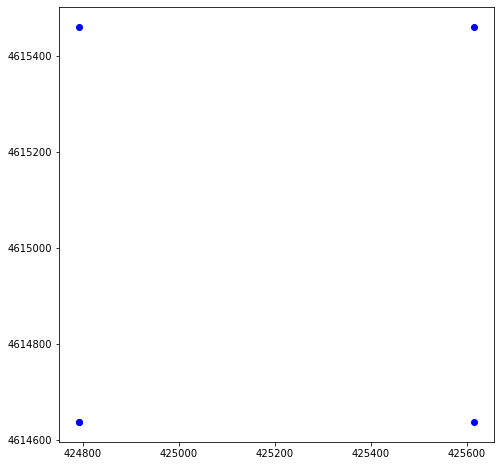

In [61]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, aspect="equal")

for i in range(len(grdverts[0])):
    print(grdverts[0][i][0])
    print(grdverts[0][i][1])
    x = grdverts[0][i][0]
    y = grdverts[0][i][1]
    ax.plot(x,y,'bo')
    #plt.set_xlim(np.min(grdverts[0])-100,)

Create instance of type ZonalDataPoly from source grid and catchment array. This needs to be done only once, then dump to file. The files that will be saved are the `src` shapefile (radar pixels), `trg` shapefile (original catchment), and `dst` shapefile (the radar pixels cut according to `trg`). 

In [62]:
%%time
# Create instance of type ZonalDataPoly from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoly(grdverts, borders)

Wall time: 23.8 s


In [63]:
%%time
# dump to file
zd.dump_vector('zonal_poly_cart_test')

Wall time: 1.72 s


In [64]:
%%time
# Create instance of type ZonalStatsPoint from zonal data object
obj3 = wrl.zonalstats.ZonalStatsPoly(zd)

Wall time: 18min 49s


### Now the looping can happen

Read the gridded data.

In [72]:
file_dir = "./gridded_600x600"
gridded_files = os.listdir(file_dir)
gridded_files = [f for f in gridded_files if f.endswith('_rrZ.hdf5')]

In [73]:
def testplot(cats, catsavg, xy, data, savefname,
             levels=[0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100, 150],
             title=""):
    """Quick test plot layout for this example file
    """
    colors = plt.cm.viridis(np.linspace(0, 1, len(levels)))
    mycmap, mynorm = from_levels_and_colors(levels, colors, extend="max")

    radolevels = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100, 150]
    radocolors = pyart.graph.cm_colorblind.HomeyerRainbow(np.linspace(0, 1, len(radolevels)))
    #pyart.graph.cm_colorblind()
    radocmap, radonorm = from_levels_and_colors(radolevels, radocolors,
                                                extend="max")

    fig = plt.figure(figsize=(18, 10))

    # Average rainfall sum
    ax = fig.add_subplot(122, aspect="equal")
    coll = PatchCollection(cats, array=catsavg, cmap=radocmap, norm=mynorm,
                           edgecolors='white', lw=0.5)
    ax.add_collection(coll)
    ax.autoscale()
    plt.colorbar(coll, ax=ax, shrink=0.5)
    plt.xlabel("NAD83 Z16 Easting")
    plt.ylabel("NAD83 Z16 Northing")
    plt.title(title)
    plt.draw()

    # Original radar data
    ax1 = fig.add_subplot(121, aspect="equal")
    pm = plt.pcolormesh(xy[:, :, 0], xy[:, :, 1], np.ma.masked_invalid(data),
                        cmap=radocmap, norm=radonorm)
    coll = PatchCollection(cats, facecolor='None', edgecolor='k', lw=0.1)
    ax1.add_collection(coll)
    cb = plt.colorbar(pm, ax=ax1, shrink=0.5)
    cb.set_label("(mm/h)")
    plt.xlabel("NAD83 Z16 Easting")
    plt.ylabel("NAD83 Z16 Northing")
    plt.title("Original radar rain sums: " + savefname.strip('.png'))
    ax1.set_xlim(bbox['left']-10000,bbox['right']+10000)
    ax1.set_ylim(bbox['bottom']-10000,bbox['top']+10000)
    #plt.draw()
    plt.tight_layout()
    fig.savefig(savefname)
    plt.close()

In [74]:
keys_str = [str(f) for f in keys]

In [75]:
gridded_files

['gridded_600x600_KLOT20130417_010000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_020000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_030000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_040000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_050000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_060000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_070000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_080000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_090000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_100000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_110000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_120000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_130000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_140000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_150000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_160000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_170000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_180000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_190000_rrZ.hdf5',
 'gridded_600x600_KLOT20130417_200000_rrZ.hdf5',
 'gridded_600x600_KL

In [76]:
# create empty dataframe where we will put the extracted values
df = pd.DataFrame()

for f in gridded_files:
    print(f)
    fn = os.path.join(file_dir, f)
    data, attrs = wrl.io.from_hdf5(fn)

    # mask data to reduce size
    data_ = data[mask]
    # Compute stats for target polygons
    avg3 = obj3.mean(data_.ravel())
    
    # Target polygon patches
    trg_patches = [patches.Polygon(item, True) for item in obj3.zdata.trg.data]
    
    # set save filename
    savefname = fn.rsplit('\\')[-1].rsplit('.')[0].strip('gridded_')+'.png'
    
    # get time
    dtime = str(dt.datetime.strptime(fn.rsplit('\\')[-1].rsplit('.')[0],'gridded_600x600_KLOT%Y%m%d_%H%M%S_rrZ'))
    
    # plot
    testplot(trg_patches, avg3, grid_xy_utm, data, savefname,
         title="Catchment rainfall mean (ZonalStatsPoly)")
    
    # put to dataframe
    df_ = pd.DataFrame(data=[avg3],columns=keys)
    df_['DateTime'] = dtime
    
    df = df.append(df_)


gridded_600x600_KLOT20130417_010000_rrZ.hdf5
gridded_600x600_KLOT20130417_020000_rrZ.hdf5
gridded_600x600_KLOT20130417_030000_rrZ.hdf5
gridded_600x600_KLOT20130417_040000_rrZ.hdf5
gridded_600x600_KLOT20130417_050000_rrZ.hdf5
gridded_600x600_KLOT20130417_060000_rrZ.hdf5
gridded_600x600_KLOT20130417_070000_rrZ.hdf5
gridded_600x600_KLOT20130417_080000_rrZ.hdf5
gridded_600x600_KLOT20130417_090000_rrZ.hdf5
gridded_600x600_KLOT20130417_100000_rrZ.hdf5
gridded_600x600_KLOT20130417_110000_rrZ.hdf5
gridded_600x600_KLOT20130417_120000_rrZ.hdf5
gridded_600x600_KLOT20130417_130000_rrZ.hdf5
gridded_600x600_KLOT20130417_140000_rrZ.hdf5
gridded_600x600_KLOT20130417_150000_rrZ.hdf5
gridded_600x600_KLOT20130417_160000_rrZ.hdf5
gridded_600x600_KLOT20130417_170000_rrZ.hdf5
gridded_600x600_KLOT20130417_180000_rrZ.hdf5
gridded_600x600_KLOT20130417_190000_rrZ.hdf5
gridded_600x600_KLOT20130417_200000_rrZ.hdf5
gridded_600x600_KLOT20130417_210000_rrZ.hdf5
gridded_600x600_KLOT20130417_220000_rrZ.hdf5
gridded_60

In [77]:
dtime

'2013-04-19 00:00:00'

In [78]:
df.to_csv('case_study_600x600_20130417_20130418_hourlyrainfall_chicago_catchments_NODEIDS_rrZ.csv')

Wall time: 5.82 s


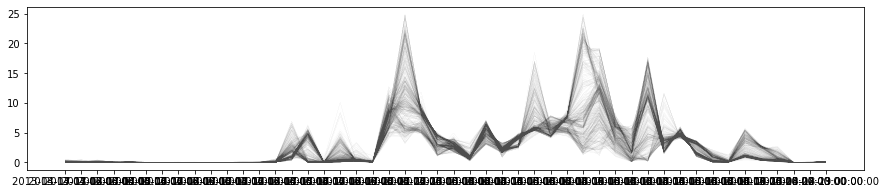

In [79]:
%%time
plt.figure(figsize=[15,3])
for key in keys[0:10000:20]:
    plt.plot(df['DateTime'], df[key], color='0.3',alpha=0.1, lw=0.1)